In [1]:
import torch
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
from src.utils import Trainer
import matplotlib.pyplot as plt
from src.preprocessing import ImdbDatabase
from src.model import TextClassifierTransformer

In [2]:
max_len = 100
batch_size = 32
num_words = 5000
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
imdb_database = ImdbDatabase(data_file_name='data/imdbdatabase.csv',  num_words = num_words, max_len=max_len, batch_size = batch_size, device = device)
train_loader, val_loader, test_loader = imdb_database.load_data()

In [3]:
d_out: int=2
n_head: int=2
d_model: int=64
epochs: int=350
dropout: float=0.75
num_embeddings: int=5000
num_encoder_layers: int=1
dim_feedforward: int = 1 * d_model

clf_model = TextClassifierTransformer(vocab_size=num_embeddings, dim_feedforward=dim_feedforward, output_dim=d_out, num_layers=num_encoder_layers, n_head=n_head, d_model=d_model, dropout=dropout)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(clf_model.parameters(), lr=1e-5)
trainer = Trainer(model=clf_model, criterion=criterion, optimizer=optimizer, device=device, without_mask=False)

In [4]:
train_losses = []
val_losses = []
train_accs = []
val_accs = []

In [5]:
test_texts = ["The storyline was gripping from start to finish, with unexpected twists and excellent performances.", "The plot felt predictable and lacked emotional depth.", "Visually stunning and well-directed, but the pacing was too slow for my taste."]
test_input_ids, test_masks = imdb_database.batch_preprocessing_text(test_texts)
test_input_ids, test_masks = test_input_ids.to("cpu"), test_masks.to("cpu")
print(test_input_ids.shape)

torch.Size([3, 100])


In [7]:
pbar = tqdm(range(epochs), desc='Epochs: ')
for epoch in pbar:
    if epoch % 50 == 0:
        # validation step
        clf_model.eval()
        clf_model.to("cpu")
        with torch.no_grad():
            test_outputs = clf_model(test_input_ids, test_masks)
            predicted = torch.argmax(test_outputs, dim=1)  
            for t, p in zip(test_texts, predicted):
                print(f"{t}: sentiment: {p}")  
    # train step
    clf_model.train()
    trainer.init_stats_params()
    for x, y, mask in train_loader:
        trainer.train_step(x, y, mask)
    train_loss = trainer.train_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accs.append(trainer.train_acc / len(train_loader.dataset))
    
    # validation step
    clf_model.eval()
    with torch.no_grad():
        for x, y, mask in val_loader:
            trainer.val_step(x, y, mask)
        eval_loss = trainer.val_loss / len(val_loader)
        val_losses.append(eval_loss)
        val_accs.append(trainer.val_acc / len(val_loader.dataset))
    pbar.set_postfix({
        'train_loss': train_loss,
        'val_loss': eval_loss,
    })
print(f'Train finished')

Epochs:   0%|          | 0/350 [00:00<?, ?it/s]

The storyline was gripping from start to finish, with unexpected twists and excellent performances.: sentiment: 1
The plot felt predictable and lacked emotional depth.: sentiment: 1
Visually stunning and well-directed, but the pacing was too slow for my taste.: sentiment: 1


Epochs:  14%|█▍        | 50/350 [01:21<08:04,  1.61s/it, train_loss=0.713, val_loss=0.682]

The storyline was gripping from start to finish, with unexpected twists and excellent performances.: sentiment: 1
The plot felt predictable and lacked emotional depth.: sentiment: 1
Visually stunning and well-directed, but the pacing was too slow for my taste.: sentiment: 1


Epochs:  29%|██▊       | 100/350 [02:42<06:34,  1.58s/it, train_loss=0.675, val_loss=0.653]

The storyline was gripping from start to finish, with unexpected twists and excellent performances.: sentiment: 1
The plot felt predictable and lacked emotional depth.: sentiment: 1
Visually stunning and well-directed, but the pacing was too slow for my taste.: sentiment: 1


Epochs:  43%|████▎     | 150/350 [04:00<05:12,  1.56s/it, train_loss=0.545, val_loss=0.458]

The storyline was gripping from start to finish, with unexpected twists and excellent performances.: sentiment: 1
The plot felt predictable and lacked emotional depth.: sentiment: 0
Visually stunning and well-directed, but the pacing was too slow for my taste.: sentiment: 1


Epochs:  57%|█████▋    | 200/350 [05:18<03:52,  1.55s/it, train_loss=0.421, val_loss=0.329]

The storyline was gripping from start to finish, with unexpected twists and excellent performances.: sentiment: 1
The plot felt predictable and lacked emotional depth.: sentiment: 0
Visually stunning and well-directed, but the pacing was too slow for my taste.: sentiment: 0


Epochs:  71%|███████▏  | 250/350 [06:36<02:35,  1.55s/it, train_loss=0.342, val_loss=0.299]

The storyline was gripping from start to finish, with unexpected twists and excellent performances.: sentiment: 1
The plot felt predictable and lacked emotional depth.: sentiment: 0
Visually stunning and well-directed, but the pacing was too slow for my taste.: sentiment: 0


Epochs:  86%|████████▌ | 300/350 [07:53<01:18,  1.56s/it, train_loss=0.28, val_loss=0.282] 

The storyline was gripping from start to finish, with unexpected twists and excellent performances.: sentiment: 1
The plot felt predictable and lacked emotional depth.: sentiment: 0
Visually stunning and well-directed, but the pacing was too slow for my taste.: sentiment: 0


Epochs: 100%|██████████| 350/350 [09:11<00:00,  1.58s/it, train_loss=0.242, val_loss=0.279]

Train finished


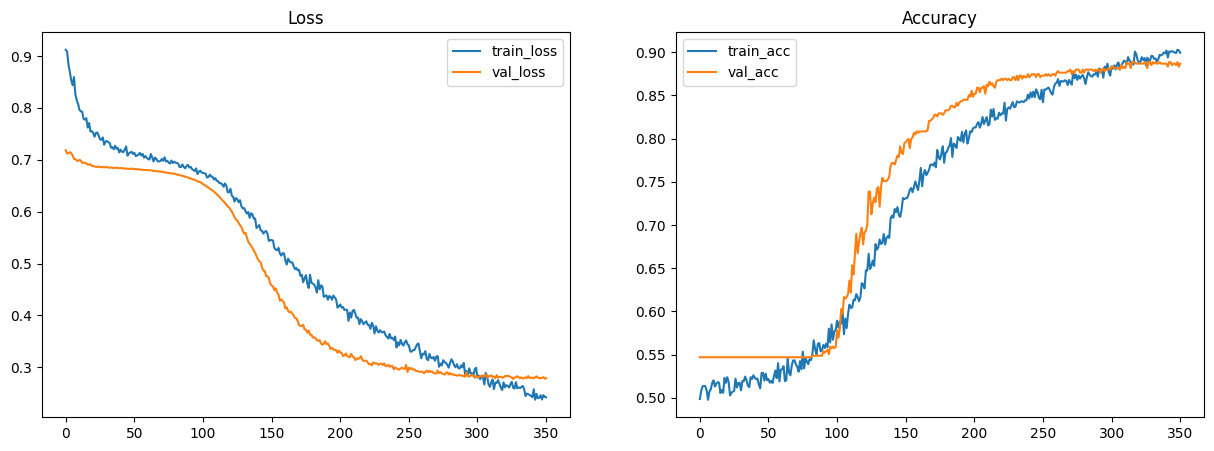

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(train_losses, label='train_loss')
axs[0].plot(val_losses, label='val_loss')
axs[0].legend()
axs[0].set_title('Loss')

axs[1].plot(train_accs, label='train_acc')
axs[1].plot(val_accs, label='val_acc')
axs[1].legend()
axs[1].set_title('Accuracy')
plt.show()

In [9]:
torch.save(clf_model.state_dict(), 'models/text_classifier_model_pool.pth')
np.savez("stats/text_classifier_model_pool.npz", train_losses=train_losses, val_losses=val_losses, train_accs=train_accs, val_accs=val_accs)

In [10]:
loss_tot = 0
correct = 0

device = torch.device("cpu" )
with torch.no_grad():  # Pas de calcul des gradients
    clf_model.eval()  # Mode évaluation
    clf_model.to(device)
    for x, y, mask in test_loader:  # Traitement par batch
        y = y.to(device)
        x = x.to(device)
        mask = mask.to(device).bool()
        # Prediction probabilities
        outputs = clf_model(x, mask)
        # Compute loss
        loss = criterion(outputs, y)
        # Prediction
        predicted = torch.argmax(outputs, dim=1)  
        correct += (predicted == y).sum().item() 
        # Loss summation
        loss_tot += loss.item()  

# Compute Accuracy
accuracy = 100 * correct / len(test_loader.dataset)
# Display test statistics
print(f'Loss: {loss_tot / len(test_loader)}') 
print(f'Accuracy: {accuracy}%') 

Loss: 0.31824053906732136
Accuracy: 89.19860627177701%
